# Processing of CEREBRIU masks

In [12]:
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

import cmbnet.preprocessing.mask_process as utils_process
from cmbnet.preprocessing.datasets.cerebriu import process_CEREBRIU_cmb, load_CEREBRIU_raw
import cmbnet.utils.utils_general as utils_general
# import utils.utils_datasets as utils_datasets
# import utils_general as utils_general
import os
from typing import Tuple, List, Dict


In [13]:

subject = "42a2a5865709f9ddc47da60a1556f09552586685"
input_dir = "/home/cerebriu/data/datasets/raw/CEREBRIU"

sequences_raw, labels_raw, sequence_type, seq_folder = load_CEREBRIU_raw(input_dir, subject)
tasks_dict = utils_general.read_json_to_dict(os.path.join(f"/home/cerebriu/data/datasets/raw/CEREBRIU/{subject}", "tasks.json"))

task_item = [it for it in tasks_dict if it['name'] == subject][0]
series_data = [seq for seq in task_item['series'] if seq['name'] == seq_folder][0] 


print(labels_raw)
label_im = labels_raw[sequence_type]
label_data = label_im.get_fdata()
mri_im = sequences_raw[sequence_type]
mri_data = mri_im.get_fdata()

# Parsing segmentMap
extracted_data = {
    "segmentMap": series_data.get("segmentMap", {}),
    "landmarks3d": series_data.get("landmarks3d", []),
    "sequence_meta": series_data.get("classifications", []),
    "study_meta": task_item.get("classification", [])

}

assert extracted_data["segmentMap"], "segmentMap is empty"
msg = ""

size_th = utils_process.calculate_size_threshold(label_im)
print()
label_mask_all = np.zeros_like(label_im.get_fdata(), dtype=bool)
all_seeds = []
rg_metadata_all = []
label_mask_list = []
# for labelid, mask_dict in extracted_data["segmentMap"].items():
idx='5'
# for labelid, mask_dict in [(str(idx), extracted_data["segmentMap"][idx])]:
for labelid, mask_dict in extracted_data["segmentMap"].items():

    print(labelid)
    multiple = mask_dict['attributes'].get('Multiple', 'false') == 'True'
    msg += f"Processing label {labelid} with {'multiple' if multiple else 'single'} CMB annotations.\n"
    
    # Convert max_dist_mm to voxel distance
    max_dist_mm = 9
    voxel_size = np.mean(label_im.header.get_zooms())  # Adjust as needed
    max_dist_voxels = max_dist_mm / voxel_size
    
    label_mask, raw_mask, seeds, cmb_metadata, msg = process_CEREBRIU_cmb(
        label_im, labelid, mri_im, size_th, max_dist_voxels, msg, multiple, show_progress=  True)

    # Check for overlap
    if np.any(label_mask_all & label_mask):
        raise RuntimeError("Overlap detected between different CMB annotated masks")

    label_mask_all |= label_mask
    all_seeds.append(seeds)
    rg_metadata_all.append(cmb_metadata)
    label_mask_list.append(label_mask)

annotation_processed_nib = nib.Nifti1Image(label_mask_all.astype(np.int16), label_im.affine, label_im.header)
processed_mask_nib, metadata, msg = utils_process.process_cmb_mask(annotation_processed_nib, msg)



nib.save(
    mri_im, "/home/cerebriu/Downloads/brain.nii.gz"
)

nib.save(
    label_im, "/home/cerebriu/Downloads/before.nii.gz"
)
nib.save(
    annotation_processed_nib, "/home/cerebriu/Downloads/after.nii.gz"
)


{'T2S': <nibabel.nifti1.Nifti1Image object at 0x7f179bce4510>}

1


Processing CMBs: 100%|██████████| 3/3 [01:04<00:00, 21.36s/it]


2


Processing CMBs: 100%|██████████| 2/2 [01:56<00:00, 58.08s/it]


3


Processing CMBs: 100%|██████████| 1/1 [00:49<00:00, 49.11s/it]


In [14]:
mask_dict

{'category': 'CMB',
 'attributes': {'Cause': 'CAA',
  '<5mm': True,
  'Location': 'Subcortical white matter'},
 'mask': '/home/cerebriu/data/datasets/raw/CEREBRIU_cmb/42a2a5865709f9ddc47da60a1556f09552586685/segmentations/42a2a5865709f9ddc47da60a1556f09552586685/T2S_0.nii.gz'}

In [15]:
print(msg)

Processing label 1 with single CMB annotations.
			Number of CMBs found in label id 1: 3.
			Processed CMB 0. n_seeds=1, new_size=109
			Processed CMB 1. n_seeds=1, new_size=8
			Processed CMB 2. n_seeds=1, new_size=2
Processing label 2 with single CMB annotations.
			Number of CMBs found in label id 2: 2.
			Processed CMB 0. n_seeds=2, new_size=70
			Processed CMB 1. n_seeds=1, new_size=38
Processing label 3 with single CMB annotations.
			Number of CMBs found in label id 3: 1.
			Processed CMB 0. n_seeds=1, new_size=32
		Number of CMBs: 6. Sizes: [109  32   8  38   2  70], Radii: [2.96, 1.97, 1.24, 2.09, 0.78, 2.56], Unique labels: [0. 1.], Counts: [15728381      259]



In [16]:
mask_dict

{'category': 'CMB',
 'attributes': {'Cause': 'CAA',
  '<5mm': True,
  'Location': 'Subcortical white matter'},
 'mask': '/home/cerebriu/data/datasets/raw/CEREBRIU_cmb/42a2a5865709f9ddc47da60a1556f09552586685/segmentations/42a2a5865709f9ddc47da60a1556f09552586685/T2S_0.nii.gz'}

In [17]:
all_seeds


[[(156, 247, 29), (189, 267, 28), (239, 129, 31)],
 [(328, 235, 33), (329, 235, 32), (217, 241, 32)],
 [(180, 184, 37)]]

65
63
[{'n_pixels': 109, 'tolerance_selected': 31.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 45, 45, 45, 45, 65, 65, 67, 67, 69, 69, 79, 79, 83, 83, 89, 89, 90, 90, 93, 93, 99, 99, 1036], 'tolerances_inspected': 65, 'elbow_i': 63}, {'n_pixels': 8, 'tolerance_selected': 55.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1036], 'tolerances_inspected': 113, 'elbow_i': 111}, {'n_pixels': 2, 'tolerance_selected': 64.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

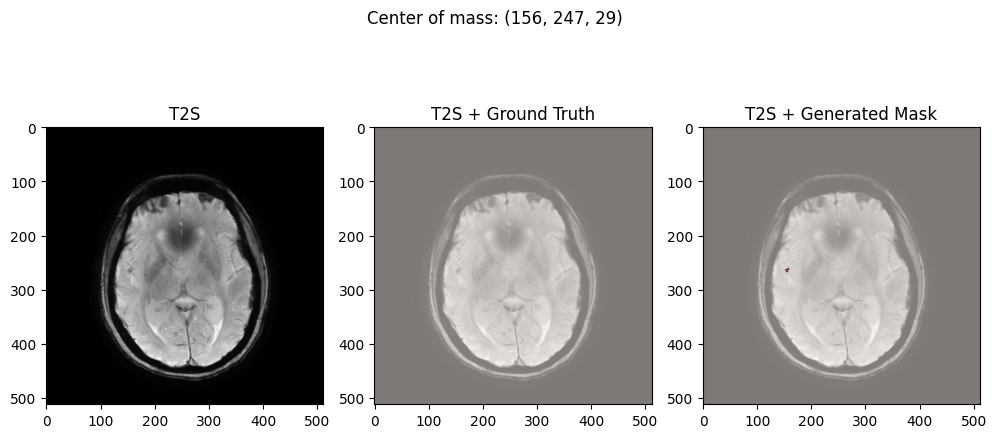

65
63
[{'n_pixels': 109, 'tolerance_selected': 31.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 45, 45, 45, 45, 65, 65, 67, 67, 69, 69, 79, 79, 83, 83, 89, 89, 90, 90, 93, 93, 99, 99, 1036], 'tolerances_inspected': 65, 'elbow_i': 63}, {'n_pixels': 8, 'tolerance_selected': 55.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1036], 'tolerances_inspected': 113, 'elbow_i': 111}, {'n_pixels': 2, 'tolerance_selected': 64.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

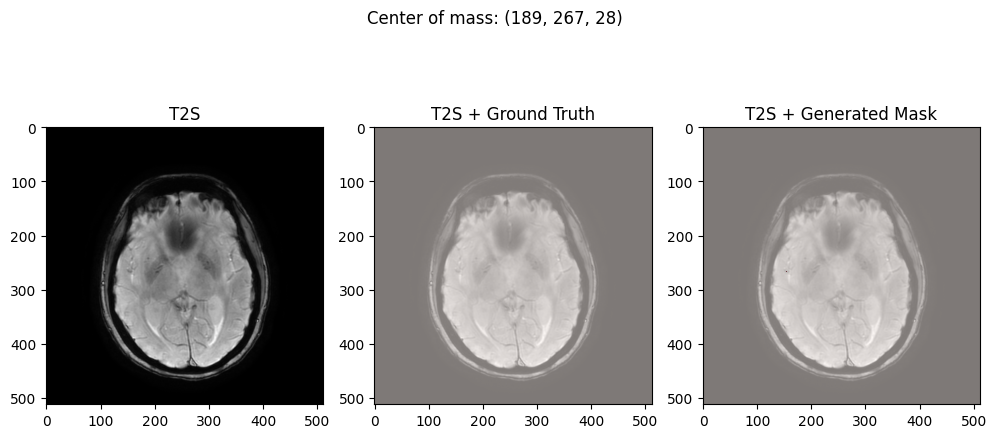

65
63
[{'n_pixels': 109, 'tolerance_selected': 31.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 45, 45, 45, 45, 65, 65, 67, 67, 69, 69, 79, 79, 83, 83, 89, 89, 90, 90, 93, 93, 99, 99, 1036], 'tolerances_inspected': 65, 'elbow_i': 63}, {'n_pixels': 8, 'tolerance_selected': 55.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1036], 'tolerances_inspected': 113, 'elbow_i': 111}, {'n_pixels': 2, 'tolerance_selected': 64.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

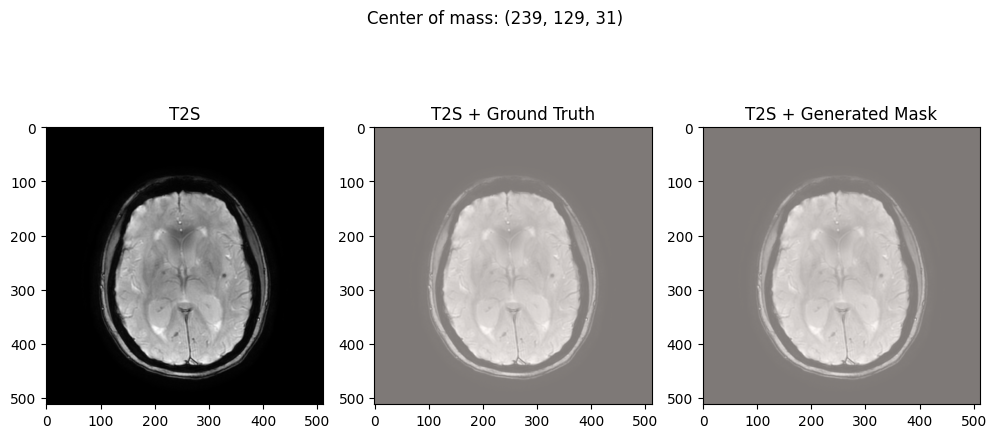

157
155
[{'n_pixels': 70, 'tolerance_selected': 77.5, 'tolerance_pixel_counts': [2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 9, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 24, 24, 26, 26, 26, 26, 26, 26, 32, 32, 32, 32, 33, 33, 33, 33, 36, 36, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 43, 43, 44, 44, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 58, 58, 58, 58, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 1036], 'tolerances_inspected': 157, 'elbow_i': 155}, {'n_pixels': 38, 'tolerance_selected': 80.5, 'tolerance_pixel_counts': [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 7, 7, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 22, 22, 22, 22, 22, 22, 22, 22, 25, 25, 25, 25, 25, 25, 26

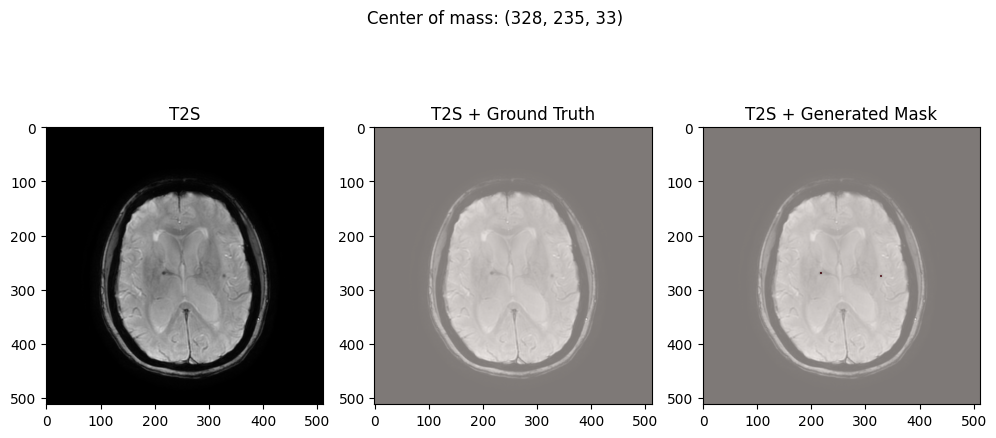

157
155
[{'n_pixels': 70, 'tolerance_selected': 77.5, 'tolerance_pixel_counts': [2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 9, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 24, 24, 26, 26, 26, 26, 26, 26, 32, 32, 32, 32, 33, 33, 33, 33, 36, 36, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 43, 43, 44, 44, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 58, 58, 58, 58, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 1036], 'tolerances_inspected': 157, 'elbow_i': 155}, {'n_pixels': 38, 'tolerance_selected': 80.5, 'tolerance_pixel_counts': [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 7, 7, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 22, 22, 22, 22, 22, 22, 22, 22, 25, 25, 25, 25, 25, 25, 26

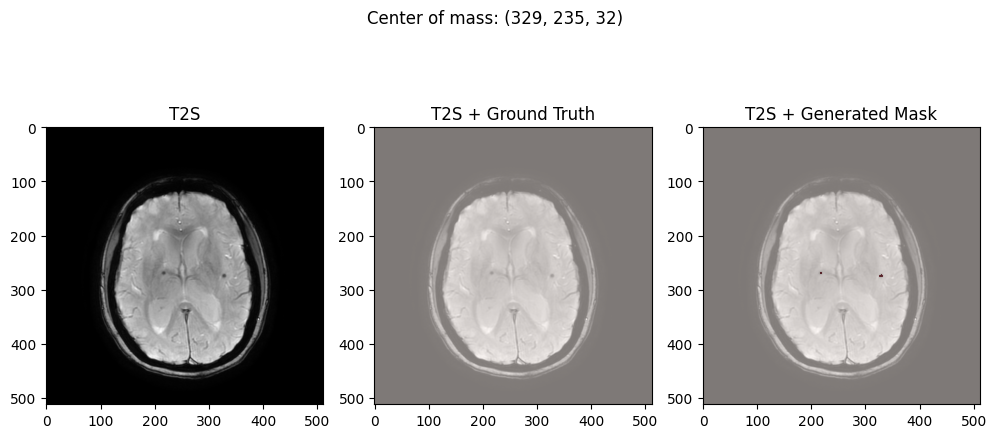

225
223
[{'n_pixels': 32, 'tolerance_selected': 111.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22, 22, 22, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1036], 'tolerances_inspected': 225, 'elbow_i': 223}]


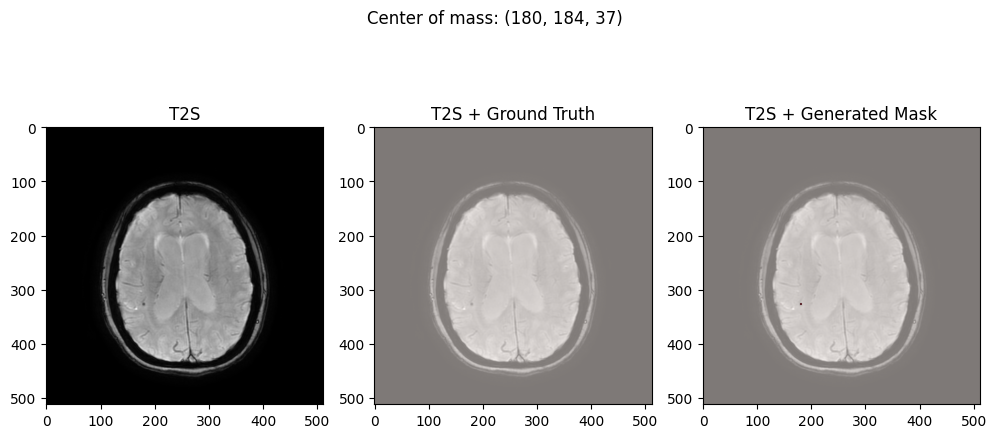

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t2s_data, cmb_data, and out_mask are numpy arrays from results_dict
t2s_data, cmb_data, out_mask = mri_im.get_fdata(), label_im.get_fdata(), processed_mask_nib.get_fdata()
CMs = metadata['centers_of_mass']

# for i in range(len(CMs)):
for ss, mm, lab in zip(all_seeds, rg_metadata_all, label_mask_list):

    out_mask = lab
    for CM, met in zip(ss, mm):
        print(mm[0]['tolerances_inspected'])
        print(mm[0]['elbow_i'])
        print(mm)
        # Creating a figure with three subplots
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))

        # Function to adjust the image for radiological view
        def adjust_for_radiological_view(image):
            return np.rot90(image)

        # Plotting raw T2 image
        axs[0].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[0].set_title('T2S')

        # Plotting ground truth overlay
        axs[1].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[1].imshow(adjust_for_radiological_view(cmb_data[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
        axs[1].set_title('T2S + Ground Truth')

        # Plotting generated mask
        axs[2].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[2].imshow(adjust_for_radiological_view(out_mask[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
        axs[2].set_title('T2S + Generated Mask')

        # # Removing axes for cleaner look
        # for ax in axs:
        #     ax.axis('off')
            
        fig.suptitle(f"Center of mass: {CM}")

        plt.tight_layout()
        # Display the plots
        plt.show()